### Case-Study Dataset: A daily minimum temperatures in Melbourne, Australia, 1981-1990

#### 0. Import libraries and define a function for data visualization

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

#### 1. Read a data file from the web, write it locally and do visualization

In [2]:
from urllib.request import urlretrieve
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv'
# saving file locally
urlretrieve(url, 'daily-min-temperatures.csv')

('daily-min-temperatures.csv', <http.client.HTTPMessage at 0x21f1758b0f0>)

In [36]:
## simply taking a look on data using pandas dataframe
df = pd.read_csv('daily-min-temperatures.csv', sep=',')
df = df.sort_values('Date', ascending=True)
df.head()

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


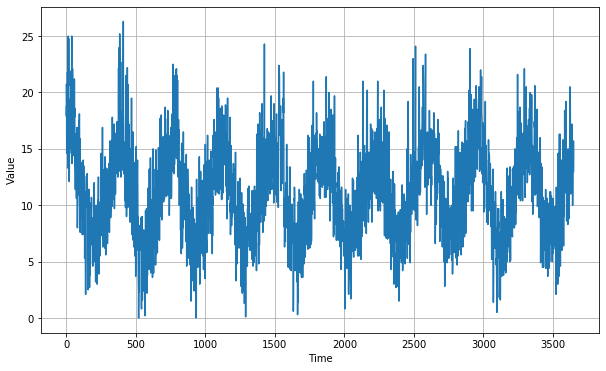

In [5]:
## explore the 10 years data
import csv
time_step = []
temps = []

with open('daily-min-temperatures.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    step=0
    for row in reader:
        temps.append(float(row[1]))
        time_step.append(step)
        step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [6]:
## split the data into train /valid sets
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

# window_size = 30
# batch_size = 32
shuffle_buffer_size = 1000


#### 2a. Turn the data into a windowed dataset through defining a helper-function and build a model with on using convolution + LSTM

In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [8]:
import tensorflow as tf
tf.keras.backend.clear_session()

tf.random.set_seed(51)
np.random.seed(51)

# set:
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

## set "call-back" at the first time
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
10/10 [==============================] - 6s 562ms/step - loss: 31.1549 - mae: 31.6551
Epoch 2/100
10/10 [==============================] - 3s 316ms/step - loss: 30.5753 - mae: 31.0783
Epoch 3/100
10/10 [==============================] - 3s 331ms/step - loss: 29.7469 - mae: 30.1792
Epoch 4/100
10/10 [==============================] - 4s 355ms/step - loss: 28.5816 - mae: 29.0582
Epoch 5/100
10/10 [==============================] - 5s 490ms/step - loss: 27.1349 - mae: 27.6970
Epoch 6/100
10/10 [==============================] - 5s 476ms/step - loss: 25.5287 - mae: 25.9975
Epoch 7/100
10/10 [==============================] - 5s 479ms/step - loss: 23.3412 - mae: 23.8407
Epoch 8/100
10/10 [==============================] - 5s 514ms/step - loss: 20.6980 - mae: 21.1120
Epoch 9/100
10/10 [==============================] - 5s 510ms/step - loss: 17.4437 - mae: 17.8083
Epoch 10/100
10/

10/10 [==============================] - 6s 573ms/step - loss: 5.4348 - mae: 5.7905
Epoch 85/100
10/10 [==============================] - 6s 580ms/step - loss: 6.0569 - mae: 6.4062
Epoch 86/100
10/10 [==============================] - 6s 580ms/step - loss: 11.4639 - mae: 12.3199
Epoch 87/100
10/10 [==============================] - 6s 626ms/step - loss: 30.4986 - mae: 31.3514
Epoch 88/100
10/10 [==============================] - 6s 629ms/step - loss: 45.7823 - mae: 47.3069
Epoch 89/100
10/10 [==============================] - 6s 580ms/step - loss: 58.6176 - mae: 58.4042
Epoch 90/100
10/10 [==============================] - 6s 583ms/step - loss: 31.3248 - mae: 34.2663
Epoch 91/100
10/10 [==============================] - 6s 565ms/step - loss: 15.9655 - mae: 16.2985
Epoch 92/100
10/10 [==============================] - 6s 574ms/step - loss: 22.1054 - mae: 22.2175
Epoch 93/100
10/10 [==============================] - 6s 570ms/step - loss: 32.4096 - mae: 33.0860
Epoch 94/100
10/10 [=======

<Figure size 432x288 with 0 Axes>

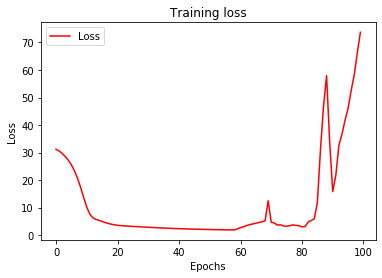

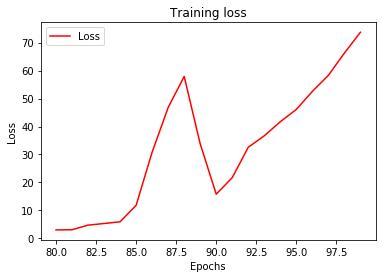

<Figure size 432x288 with 0 Axes>

In [9]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
## retrieve a list of list results on training and test data
## sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss))   ## get number of epochs

#------------------------------------------------
## plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()


## based on 100 epochs we've just done
zoomed_loss = loss[80:]
zoomed_epochs = range(80,100)

#------------------------------------------------
## plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

[1e-08, 0.001, 0, 60]

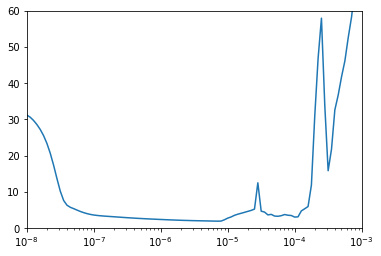

In [10]:
## we can see the same when ploting in a different way, but our model needed to be improved!

plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 60])

#### 2b. Tuning up the model we just built

In [11]:
## we will change the parameters with better values
tf.keras.backend.clear_session()

tf.random.set_seed(51)
np.random.seed(51)

window_size = 60
batch_size = 128
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=200)      ## we set 200 epochs at this time...

Epoch 1/200
20/20 [==============================] - 9s 467ms/step - loss: 11.4824 - mae: 12.3929
Epoch 2/200
20/20 [==============================] - 6s 291ms/step - loss: 3.5486 - mae: 4.0193
Epoch 3/200
20/20 [==============================] - 6s 285ms/step - loss: 2.2364 - mae: 2.6942
Epoch 4/200
20/20 [==============================] - 6s 290ms/step - loss: 1.9353 - mae: 2.3896
Epoch 5/200
20/20 [==============================] - 6s 287ms/step - loss: 1.8673 - mae: 2.3202
Epoch 6/200
20/20 [==============================] - 6s 280ms/step - loss: 1.8274 - mae: 2.2801
Epoch 7/200
20/20 [==============================] - 5s 273ms/step - loss: 1.8047 - mae: 2.2552
Epoch 8/200
20/20 [==============================] - 5s 274ms/step - loss: 1.7781 - mae: 2.2281
Epoch 9/200
20/20 [==============================] - 6s 284ms/step - loss: 1.7661 - mae: 2.2156
Epoch 10/200
20/20 [==============================] - 6s 282ms/step - loss: 1.7453 - mae: 2.1945
Epoch 11/200
20/20 [=================

20/20 [==============================] - 6s 278ms/step - loss: 1.5174 - mae: 1.9586
Epoch 86/200
20/20 [==============================] - 5s 266ms/step - loss: 1.5150 - mae: 1.9560
Epoch 87/200
20/20 [==============================] - 5s 263ms/step - loss: 1.5136 - mae: 1.9552
Epoch 88/200
20/20 [==============================] - 5s 259ms/step - loss: 1.5135 - mae: 1.9547
Epoch 89/200
20/20 [==============================] - 5s 264ms/step - loss: 1.5131 - mae: 1.9547
Epoch 90/200
20/20 [==============================] - 5s 266ms/step - loss: 1.5126 - mae: 1.9539
Epoch 91/200
20/20 [==============================] - 5s 268ms/step - loss: 1.5203 - mae: 1.9623
Epoch 92/200
20/20 [==============================] - 5s 263ms/step - loss: 1.5176 - mae: 1.9594
Epoch 93/200
20/20 [==============================] - 5s 258ms/step - loss: 1.5116 - mae: 1.9528
Epoch 94/200
20/20 [==============================] - 5s 263ms/step - loss: 1.5171 - mae: 1.9592
Epoch 95/200
20/20 [=======================

20/20 [==============================] - 5s 274ms/step - loss: 1.4969 - mae: 1.9377
Epoch 169/200
20/20 [==============================] - 5s 273ms/step - loss: 1.4931 - mae: 1.9341
Epoch 170/200
20/20 [==============================] - 6s 283ms/step - loss: 1.4929 - mae: 1.9337
Epoch 171/200
20/20 [==============================] - 6s 283ms/step - loss: 1.4928 - mae: 1.9334
Epoch 172/200
20/20 [==============================] - 5s 271ms/step - loss: 1.4924 - mae: 1.9332
Epoch 173/200
20/20 [==============================] - 5s 267ms/step - loss: 1.4928 - mae: 1.9337
Epoch 174/200
20/20 [==============================] - 5s 260ms/step - loss: 1.4949 - mae: 1.9356
Epoch 175/200
20/20 [==============================] - 5s 269ms/step - loss: 1.4936 - mae: 1.9352
Epoch 176/200
20/20 [==============================] - 5s 260ms/step - loss: 1.4931 - mae: 1.9344
Epoch 177/200
20/20 [==============================] - 5s 258ms/step - loss: 1.5076 - mae: 1.9500
Epoch 178/200
20/20 [=============

#### 3. Prediction and model estimation

In [12]:
def model_forecast(model, series, window_size):
    series = series[..., np.newaxis]               ##
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(128).prefetch(1)
    forecast = model.predict(ds)
    return forecast

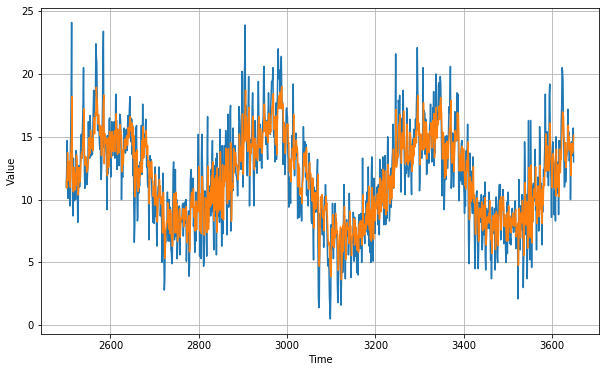

In [14]:
rnn_forecast = model_forecast(model, series, window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

## we now see our model has been improved
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

#### 4. Evaluation and MAE & MSE values

In [15]:
## the MAE value (we can see it below 2.0)
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

1.7811584

In [16]:
## the MSE value
tf.keras.metrics.mean_squared_error(x_valid, rnn_forecast).numpy()

5.2205615

In [17]:
print(rnn_forecast[:50])

[11.478561  10.918326  12.345711  13.74153   11.528404  11.542336
 12.428443  13.039948  12.226054  10.981609  13.498865  13.9647455
 15.380816  18.205456  11.576447  11.517252  10.622509  12.588864
 11.401894  10.762471  11.796227  12.077862  11.106227  13.545831
 13.076729  12.114687  12.13723   10.374342  11.0165615 12.576919
 11.535351  11.39438   11.79866   12.908851  13.619731  13.77154
 13.278998  14.271866  14.970493  15.704213  17.226324  13.641411
 13.386552  12.719     13.424911  13.070677  12.180376  12.554359
 12.363071  12.751696 ]
